In [172]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import pandas_datareader as web
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import mpld3
mpld3.enable_notebook()

In [181]:
#DATA

#Empresas para analizar:
# AAL, MSFT, TSLA (2010/07/01), GOOGL, PK
#
#
#
##

#LOAD
company = 'AAL'  #Analizaré el comportamiento de las acciones de American Airlines en este caso

start = dt.datetime(2007,5,3)
end = dt.datetime(2021,6,7)
today = dt.datetime.now()

data = pd.read_csv('AAL.csv')

#PREPARE
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 90

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [135]:
#MODEL

model = Sequential()

model.add(LSTM(units=50, return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Predicción del próximo precio

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 30, batch_size = 32)
        

Epoch 1/30
109/109 [==============================] - 14s 88ms/step - loss: 0.0341
Epoch 2/30
109/109 [==============================] - 10s 96ms/step - loss: 0.0041
Epoch 3/30
109/109 [==============================] - 11s 101ms/step - loss: 0.0039
Epoch 4/30
109/109 [==============================] - 11s 105ms/step - loss: 0.0032
Epoch 5/30
109/109 [==============================] - 12s 114ms/step - loss: 0.0028
Epoch 6/30
109/109 [==============================] - 12s 108ms/step - loss: 0.0027
Epoch 7/30
109/109 [==============================] - 12s 111ms/step - loss: 0.0028
Epoch 8/30
109/109 [==============================] - 12s 112ms/step - loss: 0.0026
Epoch 9/30
109/109 [==============================] - 13s 115ms/step - loss: 0.0023
Epoch 10/30
109/109 [==============================] - 12s 113ms/step - loss: 0.0023
Epoch 11/30
109/109 [==============================] - 13s 116ms/step - loss: 0.0021
Epoch 12/30
109/109 [==============================] - 13s 115ms/step - loss

In [148]:
#TESTING

test_data = web.DataReader(company, 'yahoo',start,today)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0) #Dataset con los datos de Test y Train
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

<function matplotlib.pyplot.show(close=None, block=None)>

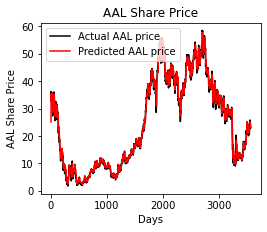

In [175]:
#PLOT

plt.plot(actual_prices,color="black", label=f"Actual {company} price")
plt.plot(predicted_prices,color="red", label=f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('Days')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.rcParams['figure.figsize'] = [10/2.54,8/2.54]
plt.show

In [176]:
predicted_prices_1d = predicted_prices.reshape(len(predicted_prices))
print(predicted_prices_1d.shape)

(3556,)


In [177]:
stocks = {'Actual':actual_prices,'Predicted':predicted_prices_1d}
final_dataset = pd.DataFrame (stocks, columns = ['Actual','Predicted'])
final_dataset.to_csv(r'..\Predictions.csv', index = False)

final_dataset_last_90_days = final_dataset.iloc[(len(predicted_prices)-90):]
final_dataset_last_90_days.to_csv(r'..\Predictions_Last_90_days.csv', index = False)

<function matplotlib.pyplot.show(close=None, block=None)>

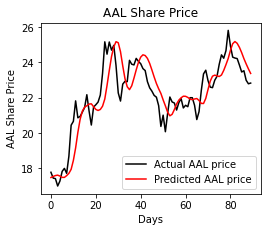

In [178]:
actual_prices_90d = final_dataset_last_90_days['Actual'].values
predicted_prices_90d = final_dataset_last_90_days['Predicted'].values

plt.plot(actual_prices_90d,color="black", label=f"Actual {company} price")
plt.plot(predicted_prices_90d,color="red", label=f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('Days')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.rcParams['figure.figsize'] = [10/2.54,8/2.54]
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

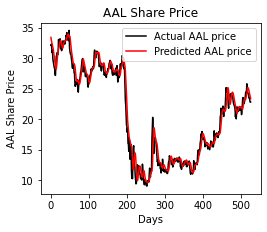

In [182]:
#Covid Effect
final_dataset_covid = final_dataset.iloc[(len(predicted_prices)-527):]
final_dataset_covid.to_csv(r'..\Predictions_covid_AAL.csv', index = False)

actual_prices_covid = final_dataset_covid['Actual'].values
predicted_prices_covid = final_dataset_covid['Predicted'].values

plt.plot(actual_prices_covid,color="black", label=f"Actual {company} price")
plt.plot(predicted_prices_covid,color="red", label=f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('Days')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.rcParams['figure.figsize'] = [10/2.54,8/2.54]
plt.show

In [180]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[23.173311]]
